In [1]:
#os and i/o
import os
import numpy as np
import glob
from os.path import abspath
import csv

#scientific computing
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
from moss import glm
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats

#ipython add-ons
from IPython.parallel import Client
from IPython.display import Image
import multiprocessing

##nipype
import nibabel as nib
from nipype.pipeline.engine import Node, MapNode, Workflow
from nipype.interfaces.io import DataGrabber, DataFinder, DataSink
from nipype.interfaces import fsl
from nipype.interfaces.fsl import ImageMeants
from nipype.interfaces.fsl import ImageStats

%matplotlib inline

In [2]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
sub_list = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)
runs = map(str,range(1,4))
exp_list = ['ser','sim']

In [3]:
roi_map = {'9':'visual','8':'frontal'}
#make image for each cluster
contrast_dir = home_dir + '/analysis/searchlight/diff/'
stat_image = contrast_dir + 'out.nii.gz'
stat_dir = contrast_dir + 'seg/'
if not os.path.exists(stat_dir):
    os.mkdir(stat_dir)
    
for index in roi_map.keys():
    
    out_f = stat_dir + roi_map[index] + '.nii.gz'
    if not os.path.exists(out_f):
        cmd = ['fslmaths',stat_image,'-thr',index,'-uthr',index,'-bin',out_f]
        os.system(' '.join(cmd))

In [4]:
#warp  mask into subject space
mask_file = home_dir + '/analysis/searchlight/diff/_tfce_corrp_tstat1.nii.gz'
print os.path.exists(mask_file)
exp = 'ser'
#warp to subject space
for sub in sub_list: 
    if True:#sub == 'fd_104':
        mask_dir =  home_dir + '/data/' + sub + '/masks/'
        out_dir = mask_dir + 'decoding/'
        if not os.path.exists(out_dir):
            os.mkdir(out_dir)
            
        warpfield = home_dir + '/data/' + sub + '/normalization/InverseWarp.nii.gz'

        #warp to subject space
        out_warp = out_dir + 'lOFC_anat_space.nii.gz'
        ref_file = fsl.Info.standard_image("avg152T1_brain.nii.gz")
        affine = home_dir + '/data/' + sub + '/normalization/affine.txt'
        anat = home_dir + '/data/' + sub + '/anat/T1_native.nii.gz'
        if not os.path.exists(out_warp):
            cmd_str = ['WarpImageMultiTransform','3',mask_file,out_warp,'-i',affine,warpfield,
                       '-R',anat]
            cmd_str = ' '.join(cmd_str)
            os.system(cmd_str)

        #register to functional space
        sub_path = home_dir + 'analysis/' + exp + '_4mm/' + sub

        #register to func
        transform = sub_path + '/preproc/run_1/func2anat_tkreg.dat'
        mean_func = sub_path + '/preproc/run_1/mean_func.nii.gz'
        out_rigid = out_dir + exp + '_lOFC_func_space.nii.gz'
        if not os.path.exists(out_rigid):
            cmd_line = ['mri_vol2vol','--mov',mean_func,'--targ',out_warp,'--reg',transform,'--o',out_rigid,
                        '--no-save-reg','--inv']
            os.system(' '.join(cmd_line))

        #mask and binarize
        out_mask = out_dir + exp + '_' + 'lOFC_mask.nii.gz'
        mask =mask_dir + 'lOFC_fill_' + exp + '.nii.gz'
        cmd = ['fslmaths',out_rigid,'-thr','.95','-mas',mask,'-bin',out_mask]
        cmd = ' '.join(cmd)
        os.system(cmd)

True


In [ ]:
#warp  mask into subject space
exp = 'ser'
#warp to subject space
for sub in sub_list: 
    if True:#sub == 'fd_104':
        mask_dir =  home_dir + '/data/' + sub + '/masks/'
        out_dir = mask_dir + 'decoding/'
            
        warpfield = home_dir + '/data/' + sub + '/normalization/InverseWarp.nii.gz'
        
        for index in roi_map.keys():
            roi = roi_map[index]
            mask_file =  stat_dir + roi + '.nii.gz'

            #warp to subject space
            out_warp = out_dir + roi + '_anat_space.nii.gz'
            ref_file = fsl.Info.standard_image("avg152T1_brain.nii.gz")
            affine = home_dir + '/data/' + sub + '/normalization/affine.txt'
            anat = home_dir + '/data/' + sub + '/anat/T1_native.nii.gz'
            if not os.path.exists(out_warp):
                cmd_str = ['WarpImageMultiTransform','3',mask_file,out_warp,'-i',affine,warpfield,
                           '-R',anat]
                cmd_str = ' '.join(cmd_str)
                os.system(cmd_str)

            #register to functional space
            sub_path = home_dir + 'analysis/' + exp + '_4mm/' + sub

            #register to func
            transform = sub_path + '/preproc/run_1/func2anat_tkreg.dat'
            mean_func = sub_path + '/preproc/run_1/mean_func.nii.gz'
            out_rigid = out_dir + exp + '_' + roi + '_func_space.nii.gz'
            if not os.path.exists(out_rigid):
                cmd_line = ['mri_vol2vol','--mov',mean_func,'--targ',out_warp,'--reg',transform,'--o',out_rigid,
                            '--no-save-reg','--inv']
                os.system(' '.join(cmd_line))

            #mask and binarize
            out_mask = out_dir + exp + '_' + roi + '_mask.nii.gz'
            cmd = ['fslmaths',out_rigid,'-thr','.95','-bin',out_mask]
            cmd = ' '.join(cmd)
            os.system(cmd)

In [12]:
#extract tsnr of ROIs
def extract_decoding(in_tuple):
    sub,exp,mask,mask_contrast = in_tuple
    cope = np.nan

    cope_f = home_dir + 'analysis/' + exp + '_8mm/' + sub + \
            '/mvpa/searchlight_state_radius8.nii.gz'

    if os.path.exists(cope_f):
        
        mask_f = home_dir + 'data/' + sub + '/masks/' + mask_contrast + '/' \
            + exp + '_' + mask + '_mask.nii.gz'
        stats = ImageStats(in_file = cope_f, op_string = '-k %s -M', mask_file = mask_f)
        out = stats.run()
        cope = out.outputs.out_stat
    
    return (sub,exp,mask,cope)

In [13]:
def parse_output(output,out_f):
    cope_df = {'roi':[],'cope':[],'sub':[],'exp':[]}
    for o in output:
        sub,exp,mask,cope = o

        cope_df['roi'].append(mask)
        cope_df['sub'].append(sub)
        cope_df['exp'].append(exp)
        cope_df['cope'].append(cope)

    cope_df = pd.DataFrame(cope_df)
    cope_df.to_csv(home_dir + '/' + out_f)
    
    return cope_df

In [7]:
in_tuples = []
for exp in ['ser']:
    for sub in sub_list:
        in_tuples.append((sub,exp,'lOFC','decoding')) 
extract_decoding(in_tuples[0])

INFO:interface:stdout 2015-10-13T13:36:38.016472:0.497830 


('fd_104', 'ser', 'lOFC', 0.49783)

In [9]:
# pool = multiprocessing.Pool(processes = 40)
# output = pool.map(extract_decoding,in_tuples)
# pool.terminate()
# pool.join()

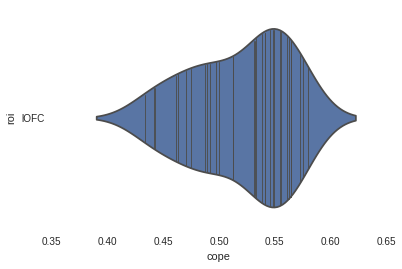

In [10]:
cope_df = parse_output(output,'state.csv')
sns.violinplot(x='cope',y='roi',data=cope_df,split=True,inner = 'stick')

In [10]:
t,p = scipy.stats.ttest_1samp(cope_df['cope'].values,.5)
print t,p

2.59737012982 0.0142419407366


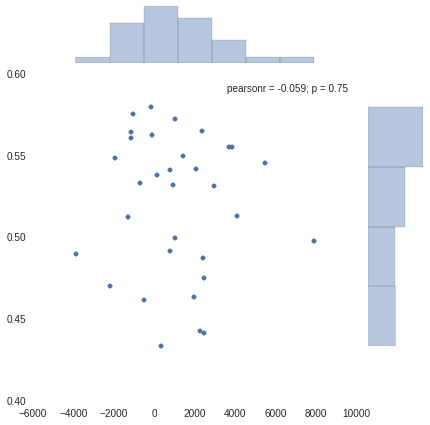

In [15]:
cope_df = parse_output(output,'state.csv')
cov = np.loadtxt(home_dir + 'vta_mb.txt')
# sns.boxplot(cov)
cope = cope_df['cope'].values
sns.jointplot(cov,cope)

In [14]:
cope_df = parse_output(output,'state.csv')
cope_df['cov'] = cov
cope_df = cope_df[cope_df['sub'] != 'fd_112']
cope_df = cope_df[cope_df['sub'] != 'fd_148']
# cope_df = cope_df[cope_df['sub'] != 'fd_113']
# cope_df = cope_df[cope_df['sub'] != 'fd_114']
# cope_df = cope_df[cope_df['sub'] != 'fd_115']
# cope_df = cope_df[cope_df['sub'] != 'fd_148']
# cope_df = cope_df[cope_df['sub'] != 'fd_124']
sns.jointplot('cope','cov',data=cope_df,kind = 'reg')
# print cope_df

NameError: name 'cov' is not defined

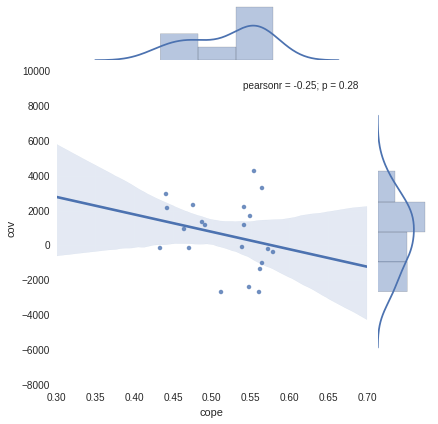

In [151]:
cope_df = parse_output(output,'state.csv')
cope_df['cov'] = cov
cope_df = cope_df[cope_df['sub'] != 'fd_104']
cope_df = cope_df[cope_df['sub'] != 'fd_108']
cope_df = cope_df[cope_df['sub'] != 'fd_110']
cope_df = cope_df[cope_df['sub'] != 'fd_112']
cope_df = cope_df[cope_df['sub'] != 'fd_113']
cope_df = cope_df[cope_df['sub'] != 'fd_122']
cope_df = cope_df[cope_df['sub'] != 'fd_133']
cope_df = cope_df[cope_df['sub'] != 'fd_135']
cope_df = cope_df[cope_df['sub'] != 'fd_144']
cope_df = cope_df[cope_df['sub'] != 'fd_147']
cope_df = cope_df[cope_df['sub'] != 'fd_148']

sns.jointplot('cope','cov',data=cope_df,kind = 'reg')
# print cope_df

In [186]:
mf = np.loadtxt(home_dir + 'vta_mf.txt')
mb = np.loadtxt(home_dir + 'vta_mb.txt')
pe = np.loadtxt(home_dir + 'vta_pe.txt')

mb_norm = mb- mf

In [49]:
def vector_rejection(a,b):
    return a - (np.dot(a,b)/np.dot(b,b) * b)

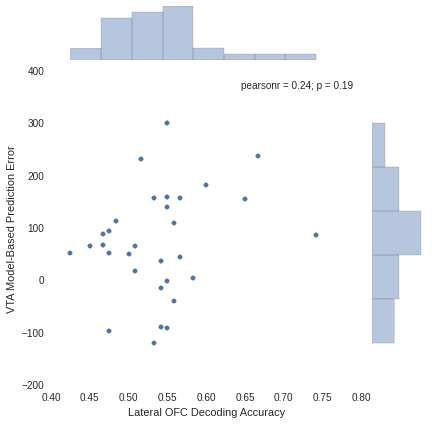

In [24]:
cope_df = parse_output(output,'state.csv')

# mf = np.loadtxt(home_dir + 'vta_mf.txt')
# mf = scipy.stats.zscore(mf)
# mb = np.loadtxt(home_dir + 'vta_mb.txt')
# mb = scipy.stats.zscore(mb)
mb = np.loadtxt(home_dir + 'vta_mb_mean.txt')
mf = np.loadtxt(home_dir + 'vta_mf_mean.txt')
vstr = np.loadtxt(home_dir + 'vstr_mb.txt')

# mb = vector_rejection(mb,mf)
sim = np.loadtxt(home_dir + 'lOFC_decoding_roi_sim.txt')
ser = np.loadtxt(home_dir + 'lOFC_decoding_roi_ser.txt')



cope_df['VTA Model-Based Prediction Error'] = mf
cope_df['Lateral OFC Decoding Accuracy'] = ser
cope_df = cope_df[cope_df['sub'] != 'fd_135']
cope_df = cope_df[cope_df['sub'] != 'fd_131']

# cope_df = cope_df[cope_df['sub'] != 'fd_110']
# cope_df = cope_df[cope_df['sub'] != 'fd_118']
# cope_df = cope_df[cope_df['sub'] != 'fd_113']
# cope_df = cope_df[cope_df['sub'] != 'fd_117']

# sns.regplot('Lateral OFC Decoding Accuracy','VTA Model-Based Prediction Error',data = cope_df,fit_reg = True, robust = True, ci = 68)
# plt.savefig(home_dir + 'decoding_vta.tiff',dpi = 300, orientation = 'landscape')
sns.jointplot('Lateral OFC Decoding Accuracy','VTA Model-Based Prediction Error',data = cope_df)


In [20]:
import statsmodels.api as sm
x = sm.add_constant(cope_df['lofc'].values)
resrlm = sm.RLM(cope_df['vta'].values,x, M = sm.robust.norms.Hampel()).fit()
print resrlm.summary()

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   31
Model:                            RLM   Df Residuals:                       29
Method:                          IRLS   Df Model:                            1
Norm:                          Hampel                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 07 Oct 2015                                         
Time:                        15:54:04                                         
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -1253.5468    753.566     -1.663      0.0

In [188]:
d =np.loadtxt(home_dir + '/analysis/omegas_powell.txt')
cope_df['omega'] = d
a = d > np.median(d)
cope_df['split'] = a
t,p = scipy.stats.ttest_ind(cope_df[cope_df['split']==True]['vta'],
                            cope_df[cope_df['split']==False]['vta'])
print t,p

0.537129683615 0.595139841851


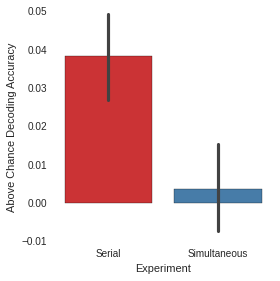

In [37]:
a = {'Above Chance Decoding Accuracy': np.hstack([ser- .5,sim - .5]),
     'Experiment':np.hstack([['Serial']*len(ser),['Simultaneous']*len(ser)])}
a = pd.DataFrame(a)
sns.factorplot('Experiment','Above Chance Decoding Accuracy',data = a,kind = 'bar',ci=68,palette = 'Set1')
plt.savefig(home_dir + 'decoding_accuracy.tiff',dpi = 300,orientation = 'landscape')